# 필수 라이브러리 임포트

In [8]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

In [9]:
from PIL import Image
import json
import matplotlib.pyplot as plt

# 학습된 모델 불러오기 


torchvision.models 에는 AlexNet, VGG, ResNet, SqueezeNet, DenseNet, Inception 등
여러 가지 학습된 모델을 제공한다. 

model = models.resnet101(pretrained=True)
사용할 모델을 가져오는 models.<모델명> 함수를 호출 시
인수로 pretrained=True 를 명시하면 학습이 완료된 모델이 사용 가능하다 .

예측값으로 0에서 부터 1000까지의 숫자를 반환한다.
해당 값은 이미지넷 데이터셋의 크랠스를 가리키는 번호로 클래스 이름과 연결지어야 한다.


CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
imagenet_samples/imagenet_classes.json 에 숫자와 클래스 제목의 매칭 정보가 담겨 있다.

idx2class = [CLASSES[str(i)] for i in range(1000) ]
파이썬에서 이 매칭 정보를 언제든 이용할 수 있도록 이 파일을 딕셔너리로 만든 후 
번호를 레이블 이름으로 변환해주는 idx2class 리스트를 만든다. 

In [39]:
# 학습된 모델 불러오기 

model = models.resnet101(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
# 데이터셋 불러오기
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000) ]


# 공격할 이미지 불러오기

img = Image.open('imagenet_samples/corgie.jpg')
이미지넷 데이터셋에는 펨브로크 웰시코기 라는 클래스가 존재하기 때문에 따로 웰시코기 사진을 준비한다. 

img_transforms = transforms.Compose([
    transforms.Resize((224,224), Image.BICUBIC),
    transforms.ToTensor(),
])
토치비전의 transforms를 이용해 이미지넷과 같은 크기인 224* 224 로 바꾸고 파이토치 텐서로 변환 

img_tensor = img_transforms(img)
img_transforms를 통과하면 어떤 이미지도 입력으로 사용 가능 


img_tensor = img_tensor.unsqueeze(0)
3* 224* 224 - > 1 * 3 * 224 * 224 : 배치를 뜻하는 1차원을 증가 

original_img_view = img_tensor.squeeze(0)
원본 이미지 텐서의 시각화를 위해 squeeze() 함수로 차원을 줄이고
original_img_view = original_img_view.transpose(0,2).transpose(0,1).detach().numpy()
detach() 함수로 원본 이미지 텐서와의 연결을 끊는다.
transpose( ) 함수로 뒤집힌 이미지를 제자리로 돌려 놓고 
numpy() 함수로 맷플롯립 라이브러리와 호환하는 넘파이 행렬로 만든다. 


In [41]:
# 이미지 불러오기
img = Image.open('imagenet_samples/corgie.jpg')

In [42]:
# 이미지를 텐서로 변환하기
img_transforms = transforms.Compose([
    transforms.Resize((224,224), Image.BICUBIC),
    transforms.ToTensor(),
])

In [43]:
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양:", img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


In [44]:
# 시각화를 위해 넘파이 행렬 변화 
original_img_view = img_tensor.squeeze(0)

In [45]:
# [1,3,244,244] -> [3,244,244]
original_img_view = original_img_view.transpose(0,2).transpose(0,1).detach().numpy()

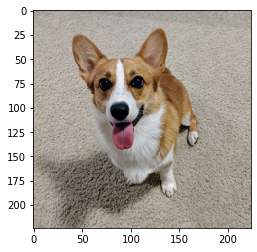

In [46]:
# 텐서 시각화 
plt.imshow(original_img_view)

# 공격 전 성능 확인하기 

공격 전에 성능을 확인한다.

output = model(img_tensor)
앞서 준비한 모델에 이미지를 통과한다. 

prediction = output.max(1,keepdim = False)[1]
max 함수를 이용해 확률이 가장 높은 인덱스, 즉 모델이 가장 확신하는 예측값을 가져 올 수 있다. 

In [21]:
# 공격 전 성능 확인하기
output = model(img_tensor)
prediction = output.max(1,keepdim = False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:" , prediction_idx)
print("레이블 이름:",prediction_name)

예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


# FGSM 공격 함수 정의

FGSM 공격의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하고 그것을 왜곡해 원본 이미지에 더한다
원본 이미지를 받아 적대적 예제를 생성하는 fgsm_attack() 함수 

sign_gradient = gradient.sign()
기울기=  모델이 학습할 떄 각 픽셀이 미치는 영향

모델을 헷갈리게 하기 위해서는 모델의 오찻값을 극대화해야 한다.
딥러닝 모델을 학습할 때는 기울기의 정반대 편으로 가중치를 조절하며 오차를 줄였다.
FGSM 공격에선 반대로 잡음이 기울기의 방향으로 최적화하도록 해서 오차를 키운다. 

sign_gradient = gradient.sign()
따라서 기울기의 방향성을 알 수 있도록 sign() 함수를 적용한다.
sign()함수는 입력이 0보다 작으면 -1을, 0이면 0, 0보다 크면 1을 출력하는 함수 

perturbed_image = image + epsilon * sign_gradient
작은 값인 epsilon을 곱한다.
epsilon은 모델 학습 시 지정해줘야 하는 학습률과 같은 개념으로 잡음이 너무 커지지 앟고
사람의 눈에 보이지 않게 제한하는 역할

결과적으로 이미지의 기울기 방향이 양수인 곳에 epsilon만큼 값을 증가시키고 
음수인 곳은 앱실론 만큼 값을 감소시키다. 



In [22]:
# FGSM 공격함수 정의
def fgsm_attack(image, epsilon, gradient):
    # 기울깃값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지의 각 픽셀값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# 적대적 예제 생성

img_tensor.requires_grad_(True) 
requires_grad_(True) 함수로 원본 이미지에 대한 기울기를 추출해서 
이미지에 대한 기울기를 저장

gradient = img_tensor.grad.data
역전파가 끝나고 나면 img_tensor의 grad.data 변수에 
입력 이미지의 기울기가 저장된다.

epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient )
FGSM 공격으로 적대적 예제 생성 

output = model(perturbed_data)
적대적 예제를 다시 모델에 통과시켜 
예측이 빗나가는지 확인

In [23]:
# 이미지의 기울기를 구하도록 설정
img_tensor.requires_grad_(True)

tensor([[[[0.6314, 0.6353, 0.6353,  ..., 0.6902, 0.6627, 0.6431],
          [0.6275, 0.6627, 0.6353,  ..., 0.6627, 0.6627, 0.6118],
          [0.6510, 0.6275, 0.6353,  ..., 0.6235, 0.6980, 0.6784],
          ...,
          [0.6549, 0.6314, 0.6118,  ..., 0.6275, 0.6627, 0.6902],
          [0.6588, 0.6863, 0.6902,  ..., 0.6431, 0.6588, 0.6392],
          [0.6392, 0.6627, 0.6863,  ..., 0.6275, 0.6392, 0.7059]],

         [[0.6157, 0.6196, 0.6196,  ..., 0.6627, 0.6353, 0.6235],
          [0.6118, 0.6431, 0.6196,  ..., 0.6353, 0.6353, 0.5843],
          [0.6353, 0.6118, 0.6196,  ..., 0.5961, 0.6706, 0.6510],
          ...,
          [0.6157, 0.5922, 0.5765,  ..., 0.6000, 0.6353, 0.6588],
          [0.6196, 0.6510, 0.6549,  ..., 0.6118, 0.6235, 0.6078],
          [0.6000, 0.6314, 0.6431,  ..., 0.6039, 0.6157, 0.6824]],

         [[0.5804, 0.5843, 0.5843,  ..., 0.6275, 0.6000, 0.5882],
          [0.5765, 0.6118, 0.5843,  ..., 0.5922, 0.5961, 0.5490],
          [0.6000, 0.5804, 0.5804,  ..., 0

In [24]:
# 원본 이미지를 모델에 통과
output = model(img_tensor)

In [26]:
#오찻값 구하기 ( 번호 263은 웰시코기)
loss = F.nll_loss(output, torch.tensor([263]))

In [27]:
#기울기값 구하기
model.zero_grad()
loss.backward()

In [28]:
# 이미지의 기울기값 추출
gradient = img_tensor.grad.data

In [29]:
# FGSM 공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient )

In [51]:
# 생성된 적대적 예제를 모델에 통과
output = model(perturbed_data)

# 적대적 예제 성능 확인

새로 만들어진 적대적 예제 이미지를 다시 똑같은 모델로 분류하면 예측 결과가 다르게 나온다.

In [31]:
# 적대적 예제 성능 확인
perturbed_prediction = output.max(1,keepdim = True)[1]
perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호: ",perturbed_prediction_idx)
print("레이블 이름: ",perturbed_prediction_name)

예측된 레이블 번호:  172
레이블 이름:  whippet


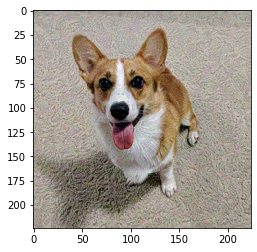

In [33]:
# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()
plt.imshow(perturbed_data_view)

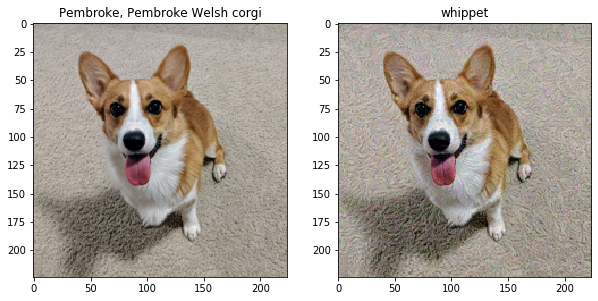

In [38]:
#원본과 적대적 예제 비교
f,a = plt.subplots(1,2, figsize = (10,10))

#원본 
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

#적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)
plt.show()